# Train the Fully Convolutional Network (FCN) baseline
Train an FCN-32s network as defined by [Long (2014)](#References) using limited hyper parameter tuning. Its performance serves as a baseline DECiSION and VOLVuLuS are compared against.

The FCN can be trained in two ways: with and without using pre-trained weights obtained after training the model on the ImageNet data set.

In [1]:
# Set Python, NumPy and TensorFlow seeds
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

# Model and training settings
import FCN_baseline_settings as settings

# Toolkit imports
from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.nn.segment import FCN32_NN, FCN32_ImageNet_NN
from dltoolkit.utils.visual import plot_training_history, plot_roc_curve,\
    plot_precision_recall_curve, print_confusion_matrix, print_classification_report
from dltoolkit.iomisc import HDF5Generator_Segment
from dltoolkit.utils.image import to_rgb

from thesis_common import convert_img_to_pred, convert_pred_to_img, create_hdf5_db,\
    show_image, read_images, read_groundtruths, print_training_info
from thesis_metric_loss import dice_coef_threshold, weighted_pixelwise_crossentropy_loss, evaluate_model

# Keras imports
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard,\
    ReduceLROnPlateau
from keras.optimizers import Adam, SGD

# scikit-learn imports
from sklearn.model_selection import train_test_split

# Other imports
import numpy as np
import os, cv2, time, progressbar
import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Change how TensorFlow allocates GPU memory
Setting `gpu_options.allow_growth` to `True` means TensorFlow will allocate GPU memory as needed rather than using all available memory from the start. This enables monitoring of actual memory usage and determining how close the notebook gets to running out of memory. This has no effect on non-GPU machines.

In [2]:
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
 
# Only allow a percentage of the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified
k.tensorflow_backend.set_session(tf.Session(config=config))

# Determine training settings
The constants below determine how the model will be trained:

- `USE_VALIDATION_SET`: set to `True` to use a validation set during training, which will be the case most of the time. Set to `False` to not use a validation set, e.g. during pipeline development/validation,
- `IS_DEVELOPMENT`: set to `True` to re-create the HDF5 files every time training is executed, `False` otherwise,
- `USE_IMAGENET`: set to `True` to use weights pre-trained on ImageNet, `False` otherwise.

**Note** if `TRN_TRAIN_VAL_SPLIT` is set to 0, a validation set will *not* be created, even if `USE_VALIDATION_SET` is set to `True`. In fact, `USE_VALIDATION_SET` will be set to `False`.

In [3]:
USE_VALIDATION_SET = True
IS_DEVELOPMENT = True
USE_IMAGENET = False

if not USE_VALIDATION_SET:
    # If no validation set is to be used override the split value
    settings.TRN_TRAIN_VAL_SPLIT = 0.0
    
if USE_IMAGENET:
    NUM_RGB_CHANNELS = 3

# Convert individual JPGs to HDF5 data sets
This function converts individual JPG files to HDF5 data sets. It creates up to four HDF5 files depending on whether a portion of the files is set aside as a validation set using the `settings.TRN_TRAIN_VAL_SPLIT` parameter.

This conversion only has to be performed once rather than prior to every training run. However, it takes very little time to run. **Note**: if any changes are made to image pre-processing applied to MRA images and/or their ground truths, the conversion MUST be executed prior to the next training run. Failing to do this means training will be performed on existing HDF5 data sets that do not include the revised pre-processing.

The folder stucture is shown below. MRA images (i.e. the individial JPG files, one for each *slice*) are located in the `images` folder. Each patient has a separate subfolder. Ground truths are located in the `groundtruths` folder, again each patient has a separate subfolder. The association between MRA image and ground truth is based on the name of the patient's subfolder **and** the alphabetically sorted file name. An MRA image/ground truth pair constitutes one training sample. The resulting HDF5 data sets are stored in the `images` and `ground truths` subfolders. The training data sets are called `train_images.h5` and `train_groundtruths.h5`. The validation sets, if they were created, are called `val_images.h5` and `val_groundtruths.h5`. 

```
---training
|     |--- images
|     |      |---patient1
|     |      |      |--- image1
|     |      |      |--- image2
|     |      |      ...
|     |      |      |--- imageM
|     |      |---patient2
|     |      ...
|     |      |---patientN
|     |--- groundtruths
|     |      |---patient1
|     |      |      |--- groundtruth1
|     |      |      |--- groundtruth2
|     |      |      ...
|     |      |      |--- groundtruthM
|     |      |---patient2
|     |      ...
|     |      |---patientN

```

In [4]:
def perform_hdf5_conversion(settings):
    """Convert the individual .jpg files (images and ground truths) to four .hdf5 files:
    - Two with the training set (train_images.h5 and train_groundtruths.h5)
    - Two with the validation set (val_images.h5 and val_groundtruths.h5)
    
    If TRN_TRAIN_VAL_SPLIT is set to zero NO validation data sets are generated.
    
    Returns the path to the HDF5 files and the number of patient folders processed.
    """
    # Prepare the path to the training images and ground truths
    img_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name)
                               for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name)
                                for e in os.scandir(msk_path) if e.is_dir()])

    # Obtain a list of paths to the training images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs,
                                                               patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=settings.IMG_EXTENSION)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=settings.IMG_EXTENSION)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Split the training set into a training and validation set. Consecutive slices no longer
    # belong to the same patient
    train_img, val_img, train_msk, val_msk = train_test_split(img_list, msk_list,
                                                              test_size=settings.TRN_TRAIN_VAL_SPLIT,
                                                              random_state=settings.RANDOM_STATE,
                                                              shuffle=True)
    
    # Create the HDF5 data sets
    output_paths = []

    # Training images
    output_paths.append(create_hdf5_db(train_img, "train", img_path,
                                       (settings.IMG_HEIGHT,
                                        settings.IMG_WIDTH,
                                        settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                       settings=settings))

    # Training ground truths
    output_paths.append(create_hdf5_db(train_msk, "train", msk_path,
                                       (settings.IMG_HEIGHT,
                                        settings.IMG_WIDTH,
                                        settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                       settings=settings,
                                       is_mask=True))

    # Validation images
    output_paths.append(create_hdf5_db(val_img, "val", img_path,
                                       (settings.IMG_HEIGHT,
                                        settings.IMG_WIDTH,
                                        settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                       settings=settings))

    # Validation ground truths
    output_paths.append(create_hdf5_db(val_msk, "val", msk_path,
                                       (settings.IMG_HEIGHT,
                                        settings.IMG_WIDTH,
                                        settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                       settings=settings,
                                       is_mask=True))

    return output_paths, len(patient_fld_imgs)

In [5]:
if IS_DEVELOPMENT:
    print("\n--- Converted images to HDF5, full paths:\n")
        
    hdf5_paths, num_patients = perform_hdf5_conversion(settings)
    
    # If TRN_TRAIN_VAL_SPLIT is set to 0 don't use a validation set, but warn the user
    if settings.TRN_TRAIN_VAL_SPLIT == 0:
        print("\nValidation split is 0.0, validation set NOT created.")
        USE_VALIDATION_SET = False
    else:
        print("\nCreated a {:.2f} split.".format(settings.TRN_TRAIN_VAL_SPLIT))
else:
    # Use existing HDF5 data sets
    hdf5_paths = ["../data/MSC8002/training/train_images.h5",
                  "../data/MSC8002/training/train_groundtruths.h5",
                  "../data/MSC8002/training/val_images.h5",
                  "../data/MSC8002/training/val_groundtruths.h5"]
    num_patients = None

Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00



--- Converted images to HDF5, full paths:

../data/MSC8002/training/train_images.h5
../data/MSC8002/training/train_groundtruths.h5
../data/MSC8002/training/val_images.h5
../data/MSC8002/training/val_groundtruths.h5

Created a 0.25 split.


# Set the class distribution
Assigning a higher weight to the positive class (i.e. blood vessels) means the model will pay "more attention" to that class. This is useful in the current class imbalance scenario because the number of background (i.e. non-blood vessel) pixels far exceed the number of blood vessel pixels. Without setting a different class weight for the blood vessel class the model would simply assign the background class to all pixels to achieve a low loss.

In [6]:
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

Class distribution: [1.0, 10.0]


# Create the FCN model
Instantiate the FCN-32s model.

In [7]:
if USE_IMAGENET:
    fcn = FCN32_ImageNet_NN(settings.IMG_HEIGHT, settings.IMG_WIDTH, NUM_RGB_CHANNELS, settings.NUM_CLASSES)
else:
    fcn = FCN32_NN(settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS, settings.NUM_CLASSES)

# Crop 16 pixels on all sides to get 256x256 images
model = fcn.build_model(crop=16, use_bn=True)

# Create paths
This cell just creates a few paths used later to save training output (e.g. the model architecture, training results and so on).

In [8]:
prefix = "FCN_baseline_" + fcn.title + "_W"+ str(settings.CLASS_WEIGHT_BLOODVESSEL) + "_" + settings.TRN_LOSS + "_BS" + "{:03}".format(settings.TRN_BATCH_SIZE)

model_path = os.path.join(settings.MODEL_PATH, prefix + ".model")
summ_path = os.path.join(settings.OUTPUT_PATH, prefix + "_model_summary.txt")
csv_path = os.path.join(settings.OUTPUT_PATH, prefix + "_training.csv")

# Save/print model architecture information
Save the model's architecture to a file, print it in the cell below and save a diagram to disk.

In [9]:
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(fcn.model, os.path.join(settings.OUTPUT_PATH, prefix))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

# Compile the model
Set the loss function, optimiser and metric and compile the model. 

In [10]:
def compile_model(model):
    # Set the optimiser, loss function and metrics
    if settings.TRN_LOSS == "ADAM":
        opt = Adam(lr=settings.TRN_LEARNING_RATE, amsgrad=settings.TRN_AMS_GRAD)
    else:
        opt = SGD(lr=settings.TRN_LEARNING_RATE)

    metrics = [dice_coef_threshold(settings.TRN_PRED_THRESHOLD)]
    loss = weighted_pixelwise_crossentropy_loss(class_weights)

    # Compile
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model, opt, loss
    
model, opt, loss = compile_model(model)

# Load data
Load data into memory.

In [11]:
train_imgs = read_images(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_groundtruths(hdf5_paths[1], settings.HDF5_KEY)

if USE_IMAGENET:
    train_imgs = to_rgb(train_imgs)
    train_grndtr = to_rgb(train_grndtr)
    
train_grndtr_ext_conv = convert_img_to_pred(train_grndtr,
                                        settings.NUM_CLASSES,
                                        settings.VERBOSE)

print("  Number of training samples: {}, gr.tr.{}\n".format(len(train_imgs), train_grndtr_ext_conv.shape))

# Read the validation set
if USE_VALIDATION_SET:
    val_imgs = read_images(hdf5_paths[2], settings.HDF5_KEY)
    val_grndtr = read_groundtruths(hdf5_paths[3], settings.HDF5_KEY)
    if USE_IMAGENET:
        val_imgs = to_rgb(val_imgs)
        val_grndtr = to_rgb(val_grndtr)
    
    val_grndtr_ext_conv = convert_img_to_pred(val_grndtr,
                                          settings.NUM_CLASSES,
                                          settings.VERBOSE)
    print("Number of validation samples: {}, gr.tr.{}\n".format(len(val_imgs), val_grndtr_ext_conv.shape))
else:
    print("Not loading a validation set.")

Loading image HDF5: ../data/MSC8002/training/train_images.h5 with dtype = float32
Loading ground truth HDF5: ../data/MSC8002/training/train_groundtruths.h5 with dtype = uint8
Elapsed time: 0.00s
  Number of training samples: 1, gr.tr.(1, 256, 256, 2)

Loading image HDF5: ../data/MSC8002/training/val_images.h5 with dtype = float32
Loading ground truth HDF5: ../data/MSC8002/training/val_groundtruths.h5 with dtype = uint8
Elapsed time: 0.00s
Number of validation samples: 1, gr.tr.(1, 256, 256, 2)



# Prepare callbacks
Prepare callbacks used during training:

- TensorBoard: basic TensorBoard visualizations (not always used)
- EarlyStopping: Stop training when a monitored quantity has stopped improving
- CSVLogger: streams epoch results to a csv file
- ModelCheckpoint: save the model after every epoch
- ReduceLROPlateau: reduce the learning when progress halts

In [12]:
def create_callbacks():
    if USE_VALIDATION_SET:
        loss_str = "val_loss"
    else:
        loss_str = "loss"

    cvs_callb = CSVLogger(csv_path, append=False)


    red_callb = ReduceLROnPlateau(monitor=loss_str,
                              factor=settings.TRN_PLAT_FACTOR,
                              patience=settings.TRN_PLAT_PATIENCE,
                              verbose=1,
                              mode="min")

    mc_callb = ModelCheckpoint(model_path,
                               monitor=loss_str,
                               mode="min",
                               save_best_only=True,
                               save_weights_only=True,
                               verbose=1)

    es_callb = EarlyStopping(monitor=loss_str,
                             min_delta=0,
                             patience=settings.TRN_EARLY_PATIENCE,
                             verbose=0,
                             mode="auto")

    return [mc_callb, es_callb, cvs_callb, red_callb]

# Train the model
Execute the training process using data loaded into memory.

In [13]:
def perform_training():
    callbacks = create_callbacks()

    if USE_VALIDATION_SET:
        print("Training with a validation set, using all data in memory.")
        print_training_info(fcn, model_path, train_imgs.shape, val_imgs.shape,
                            settings, class_weights, num_patients, opt, loss)

        # Fit the model using a training and validation set
        hist = model.fit(train_imgs, train_grndtr_ext_conv,
                         epochs=settings.TRN_NUM_EPOCH,
                         batch_size=settings.TRN_BATCH_SIZE,
                         verbose=2,
                         shuffle=True,
                         validation_data=(val_imgs, val_grndtr_ext_conv),
                         callbacks=callbacks)
    else:
        print("Training without a validation set, using all data in memory.")
        print_training_info(fcn, model_path, train_imgs.shape, None,
                            settings, class_weights, num_patients, opt, loss)

        # Fit the model using a training set only
        hist = model.fit(train_imgs, train_grndtr_ext_conv,
                         epochs=settings.TRN_NUM_EPOCH,
                         batch_size=settings.TRN_BATCH_SIZE,
                         verbose=2,
                         shuffle=True,
                         callbacks=callbacks)
        
    return hist

In [14]:
if USE_IMAGENET:
    # First warm up the model by freezing the VGG layers
    start_time = time.time()
    print("Stage 1: model \"warm-up\"")
    print("=================================")
    fcn.freeze_vgg_layers(True)    
    model, opt, loss = compile_model(model)
    perform_training()
    print("\n\nElapsed warm-up time: {:.2f} min.".format(int((time.time() - start_time))/60))
    
    # Then unfreeze all layers and train the entire model using a very small learning rate
    fcn.freeze_vgg_layers(False)
    settings.TRN_LEARNING_RATE = 0.0001
    model, opt, loss = compile_model(model)
    print("\nStage 2: train the entire network")
    print("=================================")

start_time = time.time()
hist = perform_training()
print("\n\nElapsed training time: {:.2f} min.".format(int((time.time() - start_time))/60))

Training with a validation set, using all data in memory.

Generic information:
              Model: FCN-32s_BN
          Saving to: ../savedmodels/FCN_baseline_FCN-32s_BN_W10.0_ADAM_BS001.model
 Number of patients: 1
     Training shape: (1, 256, 256, 1) (1 per patient)
   Validation shape: (1, 256, 256, 1) (1 per patient)
      Class weights: [1.0, 10.0]

Hyper parameters:
          Optimizer: <class 'keras.optimizers.Adam'>
                   : 0 = ('lr', 0.009999999776482582)
                   : 1 = ('beta_1', 0.8999999761581421)
                   : 2 = ('beta_2', 0.9990000128746033)
                   : 3 = ('decay', 0.0)
                   : 4 = ('epsilon', 1e-07)
                   : 5 = ('amsgrad', True)
       TRN_AMS_GRAD: True
               Loss: <function weighted_pixelwise_crossentropy_loss
         IMG_HEIGHT: 256
          IMG_WIDTH: 256
       IMG_CHANNELS: 1
        NUM_CLASSES: 2
        SLICE_START: 58
          SLICE_END: 60
    IMG_CROP_HEIGHT: 32
     IMG_CROP_

# Plot/save the training results
Show a plot of the training loss and Dice coefficient by epoch and save it to disk.

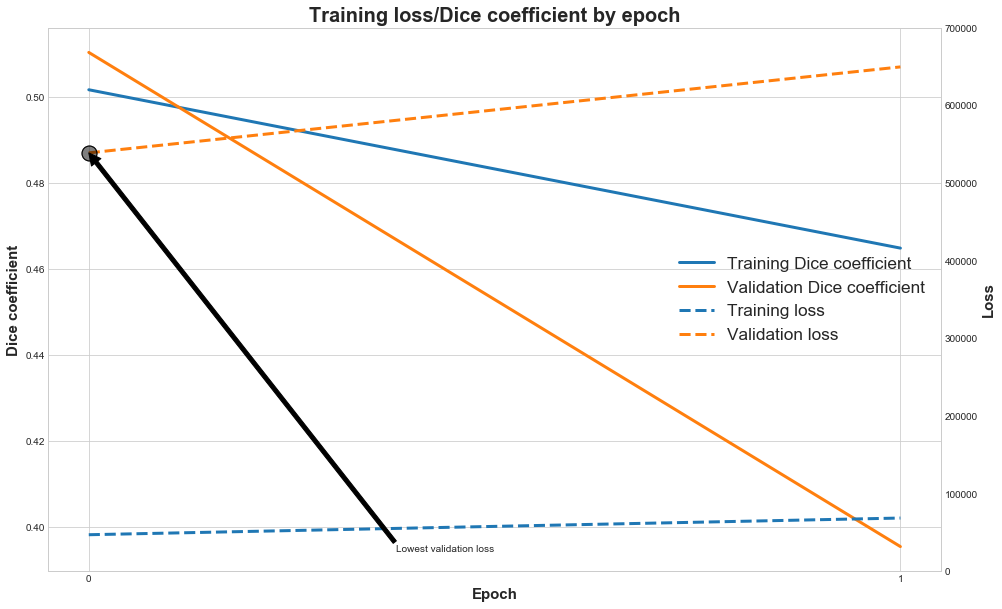

In [15]:
plot_training_history(hist,
                      show=True,
                      save_path=os.path.join(settings.OUTPUT_PATH, prefix),
                      time_stamp=True,
                      metric="dice_coef_t")

# Perform pipeline test
Use the trained model on one sample in the training data set. This is just to perform pipeline testing during development.

Loading image HDF5: ../data/MSC8002/training/train_images.h5 with dtype = float32
Loading ground truth HDF5: ../data/MSC8002/training/train_groundtruths.h5 with dtype = uint8
Predictions shape: (1, 256, 256, 2)
Elapsed time: 0.01s


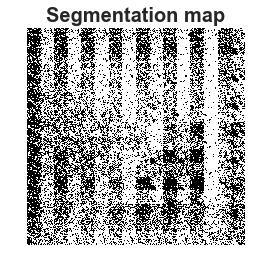

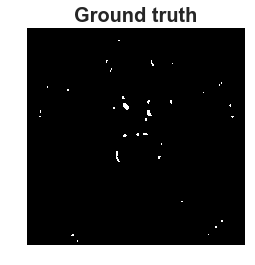

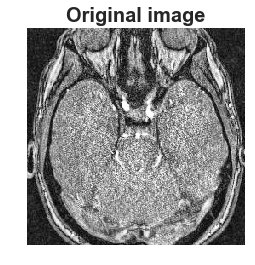

segmentation map 255 dtype uint8
    ground truth 255 dtype uint8
        original 1.0 dtype float32


In [16]:
# Read training images and ground truths
train_imgs = read_images(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_groundtruths(hdf5_paths[1], settings.HDF5_KEY)

if USE_IMAGENET:
    train_imgs = to_rgb(train_imgs)
    train_grndtr = to_rgb(train_grndtr)

# Predict
predictions = model.predict(train_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)
print("Predictions shape: {}".format(predictions.shape))

# Convert predictions to images
if USE_IMAGENET:
    predictions_imgs = convert_pred_to_img(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       num_channels=NUM_RGB_CHANNELS,
                                       verbose=settings.VERBOSE)

else:
    predictions_imgs = convert_pred_to_img(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       num_channels=settings.IMG_CHANNELS,
                                       verbose=settings.VERBOSE)

# Show a single image, ground truth and segmentation map
show_image(np.squeeze(predictions_imgs[0]), 'Segmentation map')
show_image(np.squeeze(train_grndtr[0]), 'Ground truth')
show_image(np.squeeze(train_imgs[0]), 'Original image')

print("segmentation map {} dtype {}".format(np.max(predictions_imgs[0]),
                                            predictions_imgs[0].dtype))
print("    ground truth {} dtype {}".format(np.max(train_grndtr[0]),
                                            train_grndtr[0].dtype))
print("        original {} dtype {}".format(np.max(train_imgs[0]),
                                            train_imgs[0].dtype))

# Training complete
The trained model is now ready to be applied to test MRA images using `FCN_baseline_test.ipynb`.

# References

*[Long]*: Jonathan Long, Evan Shelhamer, and Trevor Darrell. Fully Convolutional Networks for Semantic Segmentation. In *Corr*, abs/1411.4038, 2014.